In [1]:
import json
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import shutil

In [2]:
# Load label data from imprint_labels_expanded.json
with open('pill_labelling/labels/imprint_labels_expanded.json') as f:
    label_data = json.load(f)

# Create label mapping
image_to_labels = {item['image']: item['labels'] for item in label_data}
all_chars = sorted(set(label['label'] for item in label_data for label in item['labels']))
char_to_idx = {char: idx for idx, char in enumerate(all_chars)}
print(f"Classes: {len(all_chars)} characters")
print(f"Total labeled images: {len(label_data)}")

Classes: 64 characters
Total labeled images: 1145


In [3]:
# Setup YOLO dataset structure - clean first to avoid stale files
base_dir = Path('yolo_dataset')

# Remove existing dataset directory if it exists
if base_dir.exists():
    shutil.rmtree(base_dir)
    print("Removed existing yolo_dataset directory")

# Create fresh directory structure
for split in ['train', 'val']:
    (base_dir / split / 'images').mkdir(parents=True, exist_ok=True)
    (base_dir / split / 'labels').mkdir(parents=True, exist_ok=True)

# Split data - use only images from imprint_labels_vetted.json
image_names = [item['image'] for item in label_data]
train_imgs, val_imgs = train_test_split(image_names, test_size=0.15, random_state=42)
print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}")

Removed existing yolo_dataset directory
Train: 973, Val: 172


In [4]:
# Convert to YOLO format and copy images
image_source = Path('data/pillbox_production_images_full_202008')

for img_name, split in [(img, 'train') for img in train_imgs] + [(img, 'val') for img in val_imgs]:
    src = image_source / img_name
    if not src.exists():
        continue
    
    # Copy image
    dst_img = base_dir / split / 'images' / img_name
    shutil.copy(src, dst_img)
    
    # Create YOLO label file
    labels = image_to_labels[img_name]
    label_path = base_dir / split / 'labels' / f"{Path(img_name).stem}.txt"
    
    with open(label_path, 'w') as f:
        for label in labels:
            cls = char_to_idx[label['label']]
            coords = label['coords'].split()
            x, y, w, h = map(float, coords)
            # Ensure coords are in valid range [0, 1]
            x, y, w, h = max(0, min(1, x)), max(0, min(1, y)), max(0, min(1, w)), max(0, min(1, h))
            f.write(f"{cls} {x} {y} {w} {h}\n")

print("Dataset prepared")

Dataset prepared


In [5]:
# Create YOLO config file
import yaml

config = {
    'path': str(base_dir.absolute()),
    'train': 'train/images',
    'val': 'val/images',
    'nc': len(all_chars),
    'names': all_chars
}

with open(base_dir / 'data.yaml', 'w') as f:
    yaml.dump(config, f, default_flow_style=False)

print("Config created")

Config created


In [7]:
# Train YOLO model
model = YOLO('yolov8n.pt')
results = model.train(
    data=str(base_dir / 'data.yaml'),
    epochs=50,
    imgsz=640,
    batch=16,
    name='pill_imprint_v17'  # Training with expanded labels
)

New https://pypi.org/project/ultralytics/8.3.234 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.233 🚀 Python-3.13.2 torch-2.9.1 CPU (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pill_imprint_v17, nbs=64, nms=False, opset=None, optimize=False

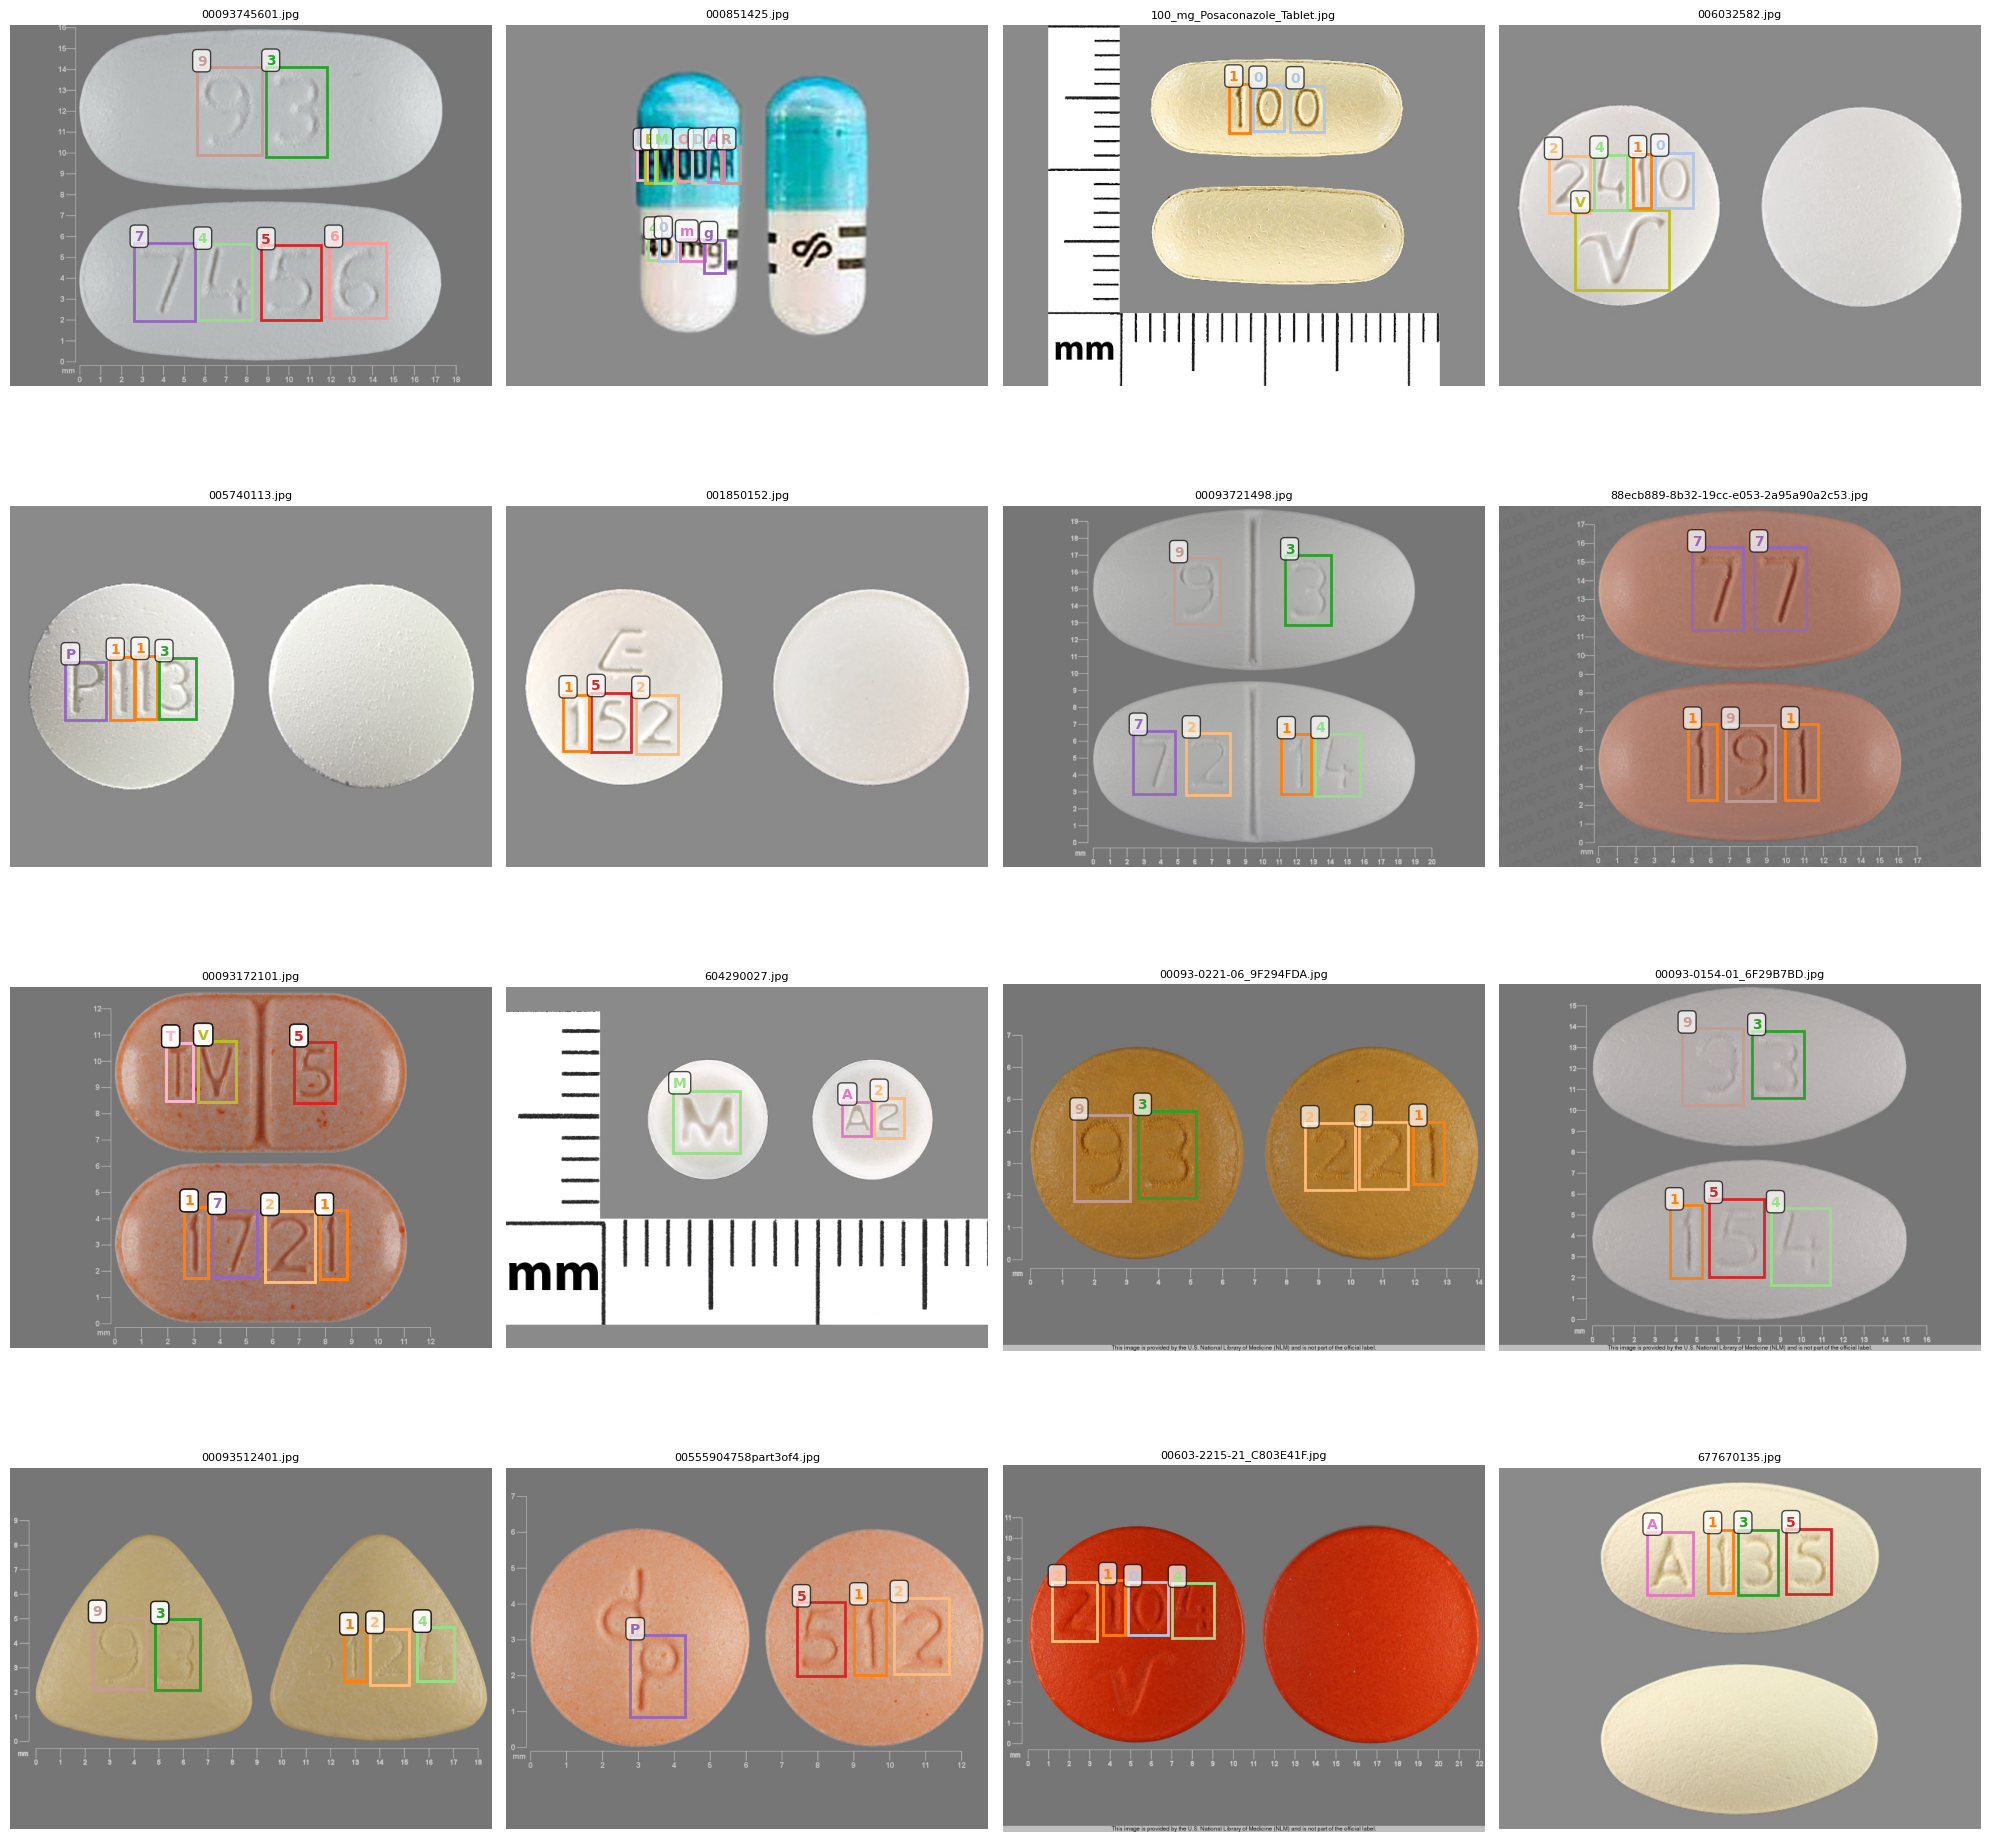

Created validation preview with 16 images
Saved to: validation_preview.jpg


In [6]:
# Simulate YOLO val_batch1_label.jpg - 4x4 grid of images with bounding boxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random
import numpy as np

# Randomly select 16 images from label_data
random.seed(42)
selected_items = random.sample(label_data, min(16, len(label_data)))

# Create 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

# Color map for different classes (cycle through colors)
colors = plt.cm.tab20(np.linspace(0, 1, 20))

for idx, item in enumerate(selected_items):
    ax = axes[idx]
    
    # Load and display image
    img_path = image_source / item['image']
    if img_path.exists():
        img = Image.open(img_path)
        ax.imshow(img)
        
        # Get image dimensions
        img_width, img_height = img.size
        
        # Draw bounding boxes
        for label in item['labels']:
            # Parse normalized coordinates
            coords = label['coords'].split()
            x_center, y_center, width, height = map(float, coords)
            
            # Convert from normalized YOLO format (center x, center y, width, height)
            # to pixel coordinates (top-left x, top-left y, width, height)
            x_pixel = (x_center - width/2) * img_width
            y_pixel = (y_center - height/2) * img_height
            w_pixel = width * img_width
            h_pixel = height * img_height
            
            # Get color for this class
            cls_idx = char_to_idx[label['label']]
            color = colors[cls_idx % len(colors)]
            
            # Draw rectangle
            rect = patches.Rectangle(
                (x_pixel, y_pixel), w_pixel, h_pixel,
                linewidth=2, edgecolor=color, facecolor='none'
            )
            ax.add_patch(rect)
            
            # Add label text
            ax.text(
                x_pixel, y_pixel - 5,
                label['label'],
                color=color,
                fontsize=10,
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
            )
    else:
        ax.text(0.5, 0.5, f'Image not found:\n{item["image"]}', 
                ha='center', va='center', transform=ax.transAxes)
    
    ax.axis('off')
    ax.set_title(item['image'], fontsize=8)

plt.tight_layout()
plt.savefig('validation_preview.jpg', dpi=150, bbox_inches='tight')
plt.show()

print(f"Created validation preview with {len(selected_items)} images")
print(f"Saved to: validation_preview.jpg")